# Анализ рекламных источников мобильной игры «Космические братья»

**Цель проекта: проанализировать поведение пользователей и определить канал привлечения, наиболее перспективный для предполагаемой модели монетизации**

Задачи:
- определить какими стратегиями пользуются игроки: в целом/по каналам привлечения
- как часто совершается "целевое" действие (постройка объекта, так как реклама будет размещаться в окне выбора типа объекта для строительства): в целом/по каналам привлечения
- какой канал дает пользователей с бОльшей вовлеченностью - то есть тех, кто перешел на 2 уровень
- проанализировать время прохождения уровня: в целом/по каналам привлечения
- проанализировать стоимость привлечения пользователя: в целом/по каналам привлечения
- оценим окупаемость предлагаемой модели монетизации
- дать объединенную оценку каждому каналу: вовлеченность пользователя и стоимость привлечения
- назвать каналы, потенциально более привлекательные для монетизации 

## Описание данных

**Объект анализа** - мобильная игра «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.



**Для анализа были предоставлены три датасета:**

**game_actions.csv**: представлены данные по игре пользователей на первом уровне. *Завершение первого уровня требует от игрока выполнения одного из двух условий: победа над первым врагом или реализация проекта (проект для первого уровня - разработка орбитальной сборки спутников). До реализации проекта или участия в битве игрок строит три типа зданий, выбор типа постройки зависит от пользователя, строить можно любое количество зданий любого типа. Для прохождения уровня через реализацию проекта - нужно предварительно построить хотя бы один исследовательский центр. Для участия в войне - нужно набрать армию, предварительно построив космопорт/космопорты. Строительство будет идти быстрее, если построить достаточное количество сборочных цехов. После реализации проекта пользователь может сразу же добровольно перейти на следующий уровень, нажав соответствующую кнопку, или остаться в игре на уровне: продолжить строить или пойти воевать. Пользователь, решивший воевать без реализации проекта, после победы над противником автоматически переходит на следующий уровень.* 



ОПИСАНИЕ ДАННЫХ

**game_actions.csv**: В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

- `event_datetime` — время события;


- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
    
    
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
    
    
    
- `user_id` — идентификатор пользователя;



- `project_type` — тип реализованного проекта;

**ad_cost.csv**: в датасете собрана информация о рекламных расходах с 3 по 9 мая, по каналам привлечения в разрезе каждого дня. Платеж за клики авансовый, то есть платим сегодня за завтрашних пользователей.

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

**user_source.csv** в датасете собраны данные по пользователям, из какого рекламного канала они пришли в игру.

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение


**Основная монетизация игры** — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки, установлена фиксированная цена за рекламу в игре - 0.07 у.е.

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import math as mth
from datetime import datetime as dt, timedelta
from matplotlib import pyplot as plt
from scipy import stats as st
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# загружаем данные
game = pd.read_csv('')
cost = pd.read_csv('')
source = pd.read_csv('')

## Предобработка данных

- посмотрим и оценим датасеты
- оценим пропуски, дубликаты
- приведем к нужным типы данных
- обработаем данные о времени: приведем к нужному формату; сдвинем даты в таблице с рекламными расходами, для унификации дат

In [3]:
def preview (data):
    '''
       Функция для предварительного просмотра данных
    '''
    print('Посмотрим на данные')
    display(data.head())
    print('-'*50)
    print()
    print('Атрибуты')
    print(data.info())
    print('-'*50)
    print()
    print('Пропусков в данных')
    print(data.isna().sum())
    print('-'*50)
    print()
    print('Полных дубликатов в данных - ', data.duplicated().sum())
       

In [4]:
preview(game)

Посмотрим на данные


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


--------------------------------------------------

Атрибуты
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
None
--------------------------------------------------

Пропусков в данных
event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64
--------------------------------------------------

Полных дубликатов в данных -  1


Датасет из 135640 записей, 5 столбцов. В столбцах building_type, project_type пропуски, связанные с механикой игры. Тип данных в столбце с датами - object, приведем его к типу datetime. Полных дублей - 1, удалим.


**Дубликаты**

In [5]:
# явные дубликаты удаляем
game = game.drop_duplicates().reset_index(drop=True)

In [6]:
# проверяем неявные
print(game['event'].unique(), game['building_type'].unique(), game['project_type'].unique())

['building' 'finished_stage_1' 'project'] ['assembly_shop' 'spaceport' nan 'research_center'] [nan 'satellite_orbital_assembly']


Полный дубликат удалили, неявных дублей нет.

**Столбец с датами**

In [7]:
# приводим к нужному типу
game['event_datetime'] = pd.to_datetime(game['event_datetime'])

In [8]:
# проверяем внесенные изменения
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135639 entries, 0 to 135638
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB


In [9]:
preview(cost)

Посмотрим на данные


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


--------------------------------------------------

Атрибуты
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
None
--------------------------------------------------

Пропусков в данных
source    0
day       0
cost      0
dtype: int64
--------------------------------------------------

Полных дубликатов в данных -  0


Небольшой датасет, всего 28 строк. В целом данные чистые, проверим только неявные дубликаты в столбце source и поменяем тип данных в столбце с датой

In [10]:
# уникальные значения столбца, проверяем неявные дубликаты
cost['source'].unique()

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

In [11]:
# дату приводим к нужному типу, добавляем день к дате для унификации (платежи авансовые)
cost['day'] = pd.to_datetime(cost['day'])
cost['day'] = cost['day'] + timedelta(days=1)

In [12]:
# проверяем тип данных и даты
print(cost['day'].dtypes)
display(cost.head(10))

datetime64[ns]


,source,day,cost
0,facebook_ads,2020-05-04,935.882786
1,facebook_ads,2020-05-05,548.354480
2,facebook_ads,2020-05-06,260.185754
3,facebook_ads,2020-05-07,177.982200
4,facebook_ads,2020-05-08,111.766796
5,facebook_ads,2020-05-09,68.009276
6,facebook_ads,2020-05-10,38.723350
7,instagram_new_adverts,2020-05-04,943.204717
8,instagram_new_adverts,2020-05-05,502.925451
9,instagram_new_adverts,2020-05-06,313.970984


In [13]:
preview(source)

Посмотрим на данные


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


--------------------------------------------------

Атрибуты
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
None
--------------------------------------------------

Пропусков в данных
user_id    0
source     0
dtype: int64
--------------------------------------------------

Полных дубликатов в данных -  0


In [14]:
# проверка на неявные дубликаты
source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

Неявных дублей нет.

### Итоги

**В данных 'game' есть пропуски, все они связаны с механикой игры, заполнять и удалять их не стали, так как они тоже источник информации. Был удален 1 полный дубликат. Во всех таблицах данные о времени приведены к нужному типу.**

## Исследовательский анализ

Исследуем данные в каждой таблице.

В данных **game**:
- оценим количество событий:  всего, по типам, по дням 
- назовем какой тип здания предпочитают пользователи
- узнаем за какое время мы располагаем данными, построим график распределения событий во времени

In [15]:
#исследование данных в таблице "game"
count_event = game['event'].nunique()
print ('Уникальных событий -', count_event)
    
total_event = game['event'].count()
print ('Всего событий -', total_event)
    
count_user = game['user_id'].nunique()
print('Пользователей -', count_user)
   
cnt_building = game[game['event'] == 'building']['user_id'].count()
print(f'Пользователи построили - {cnt_building} зданий')
print('В среднем на пользователя приходится -', round((cnt_building/count_user),2), 'построек')

finish = game[game['event'] == 'finished_stage_1']['user_id'].count()
per_finished = round((finish/count_user * 100),2)
print(f'Закончили играть 1 уровень - {finish} пользователей, это - {per_finished}% (от общего количества):')

project = game[game['event'] == 'project']['user_id'].count()
per_project = round((project/finish * 100),2)
print(f'из них закончили играть 1 уровень и реализовали проект (исследователи) - {project} пользователей, это {per_project}% от закончивших игру,')

war = finish - project
per_war = round((war/finish * 100),2)
print(f'закончили играть 1 уровень одержав победу (воители) - {war} пользователей, это - {per_war}% от закончивших игру.')
 

Уникальных событий - 3
Всего событий - 135639
Пользователей - 13576
Пользователи построили - 127956 зданий
В среднем на пользователя приходится - 9.43 построек
Закончили играть 1 уровень - 5817 пользователей, это - 42.85% (от общего количества):
из них закончили играть 1 уровень и реализовали проект (исследователи) - 1866 пользователей, это 32.08% от закончивших игру,
закончили играть 1 уровень одержав победу (воители) - 3951 пользователей, это - 67.92% от закончивших игру.


Всего построено 127956 зданий.


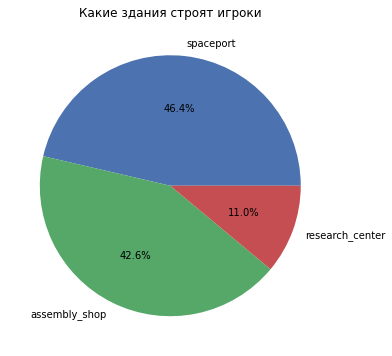

In [16]:
# узнаем общее количество зданий и создаем круговую диаграмму для типов построек

print('Всего построено', game.query('event == "building"')['building_type'].count(), 'зданий.')

f, ax = plt.subplots(figsize=(15,6 ))
with plt.style.context('seaborn-deep'):
    game['building_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Какие здания строят игроки')
ax.set_ylabel('')
plt.show()

- БОльшая часть пользователей (67.92%) - воители: закончили уровень после победы над врагом, соответственно  и самый популярный тип зданий 46.4% - космопорты (spaceport - там где, игрок может генерировать армию).
- Практически столько же построек типа сборочный цех (assembly_shop)  42.6% - что хорошо для игры, пользователи активно создают постройки для реализации своей космической программы, значит вовлечены в игру.
- Всего 11% зданий от всех построенных - исследовательские центры, это также закономерно, так как в 1 уровне для реализации проекта нужен хотя бы 1 исследовательский центр.

Мы располагаем данными о событиях с 2020-05-04 00:00:01 по 2020-06-05 12:32:49


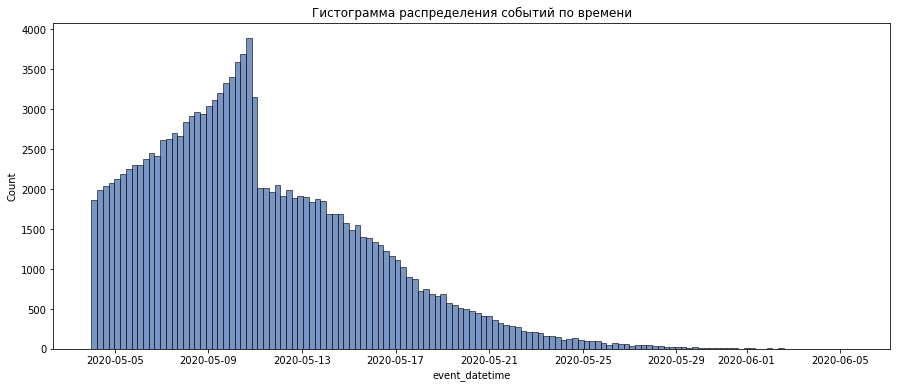

In [17]:
#гистограмма распределения событий по времени
print('Мы располагаем данными о событиях с', game['event_datetime'].min(), 'по', game['event_datetime'].max())

sns.set_palette('deep')
f, ax = plt.subplots(figsize=(15,6 ))
sns.histplot(data = game, x = 'event_datetime') 
plt.title(f'Гистограмма распределения событий по времени')
plt.show()

Распределение событий во времени подтверждает наши исходные данные - до 10 мая количество событий растет, так как привлекались новые пользователи, после - количество событий уменьшается: кто-то уже прошел на следующий уровень, кто-то перестал играть, кто-то еще играет уровень.


Далее посмотрим таблицу с рекламными расходами по каналам привлечения - **cost**.
- оценим общую сумму рекламных расходов, сумму по каналам привлечения, визуализируем рекламные расходы по источникам с привязкой к датам (с 4 по 10 мая)


In [18]:
#общие затраты на рекламу
round((sum(cost['cost'])),2)

7603.58

In [19]:
# расходы на рекламу с разбивкой по рекламным каналам
round((cost.groupby('source')['cost'].sum()),2)

source
facebook_ads               2140.90
instagram_new_adverts      2161.44
yandex_direct              2233.11
youtube_channel_reklama    1068.12
Name: cost, dtype: float64

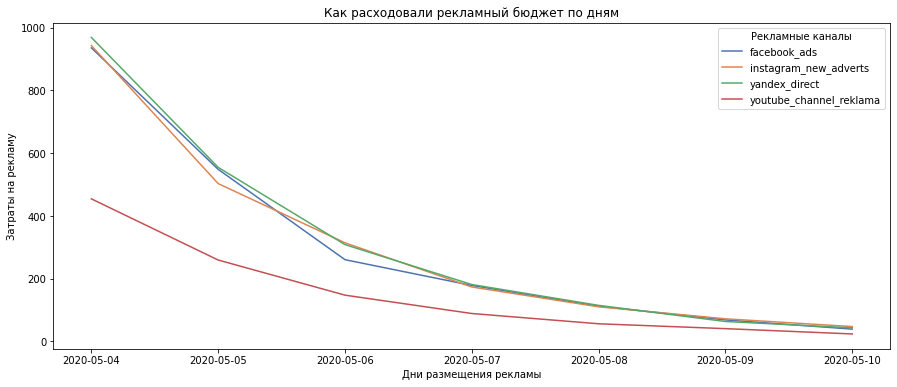

In [20]:
# построим график рекламных расходов по источникам с привязкой к датам (с 4 по 10 мая)
f, ax = plt.subplots(figsize=(15,6 ))
sns.lineplot(data = cost, x = 'day', y = 'cost', hue='source') 
plt.title(f'Как расходовали рекламный бюджет по дням')
ax.legend(title='Рекламные каналы')
ax.set_xlabel('Дни размещения рекламы')
ax.set_ylabel('Затраты на рекламу')
plt.show()

Общий рекламный бюджет - 7603 у.е.

*Предположу, что околопраздничные и праздничные дни были выбраны для рекламы с тем рассчетом, чтобы для запуска нового продукта "поймать в интернете" уже практически отдыхающую и отдыхающую аудиторию на длинных майских праздниках, использовать по максимуму эффект новизны. Запуск рекламы 4 мая может быть связан с тем, что после первых нескольких дней отдыха (когда, все дела переделаны, или до места отдыха добрались) люди чаще идут в интернет и соцсети. Сумму на оплату привлечения игроков уменьшали, возможно, надеясь на органиков или уже получив достаточное количество органических пользователей*

Примерно одинаковое количество денег было потрачено на  фэйсбук, инстаграм и яндекс-директ. В два раза меньший бюджет получил ютуб.

Посмотрим из каких рекламных источников пришли игроки - данные **source**

In [21]:
source['source'].value_counts()

yandex_direct              4817
instagram_new_adverts      3347
facebook_ads               2726
youtube_channel_reklama    2686
Name: source, dtype: int64

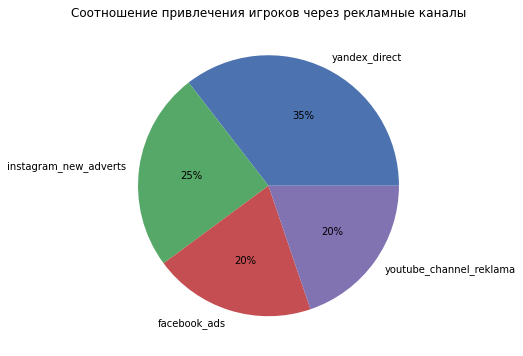

In [22]:
f, ax = plt.subplots(figsize=(15,6 ))
with plt.style.context('seaborn-deep'):
    source['source'].value_counts().plot(
        kind='pie', autopct='%1.0f%%', title='Соотношение привлечения игроков через рекламные каналы'
    )
ax.set_ylabel('')
plt.show()

- реклама в яндекс-директ показала большую эффективность, при практически равном бюджете привлекла на 10% пользователей больше чем инстаграм и на 15% больше пользователей, чем фэйсбук
- на ютуб потратили в 2 раза меньше, при этом пользователей он привлек столько же, сколько и фэйсбук

### Итоги

- Всего событий, совершенных игроками с 4 мая по 5 июня - 135639. По событиям мы выяснили, что закончили уровень и перешли на следующий 42.85% игроков от общего количества. Из них 68% игроков закончили уровень, одержав победу в сражении, 32% пользователей использовали стратегию выполнения проекта.

- Всего игроков - 13576, из них - 35% пришли из яндекс-директ, 25% - из инстаграмм, по 20% из фэйсбука и ютуба.

- Пользователи построили - 127956 зданий, самые популярные типы зданий космопорты и сборочные цеха.

- Расходы на рекламу - 7603 у.е. Примерно поровну был распределен бюджет между Яндекс-директ(2233 у.е.), инстаграм(2161 у.е.) и фэйсбук (2140у.е.). В два раза меньше денег получил ютуб.

## Анализ рекламных источников

### Объединяем данные для анализа

Перед анализом рекламных источников создадим сводную таблицу, в которой преобразуем данные, а также опишем ее.

In [23]:
# создаем сводную таблицу, группируя по user_id, сохраняя значимые для нас данные из 'event'
pivot = game.pivot_table(
    index='user_id', columns='event', values = 'event_datetime', aggfunc = ['count', 'first', 'last']
).fillna(0).reset_index()

# переименовываем столбцы
pivot.columns = [
    'user_id','cnt_session', 'finished_stage_1', 'strategy_project',
    'start_flag', 'finish_flag', 'project_flag', 'last_action', 'd', 'dd'
]

# смотрим данные
pivot.head()

,user_id,cnt_session,finished_stage_1,strategy_project,start_flag,finish_flag,project_flag,last_action,d,dd
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13.0,0.0,0.0,2020-05-06 01:07:37,0,0,2020-05-20 11:26:06,0,0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9.0,0.0,0.0,2020-05-06 03:09:12,0,0,2020-05-18 10:46:52,0,0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4.0,0.0,0.0,2020-05-05 18:08:52,0,0,2020-05-14 09:21:27,0,0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8.0,1.0,0.0,2020-05-05 21:02:05,2020-05-12 07:40:47,0,2020-05-12 04:14:25,2020-05-12 07:40:47,0
4,002f508f-67b6-479f-814b-b05f00d4e995,12.0,0.0,0.0,2020-05-05 13:49:58,0,0,2020-05-22 02:46:45,0,0


Механизм прохождения уровня разрешает пользователю многократное событие building - столбец cnt_building, и только однократное событие project и finished_stage_1 - одноименные столбцы после группировки стали столбцами с бинарными данными (1-да, 0-нет). Из-за этой же особенности мы уберем столбцы d  и dd, так как они дублируют столбцы finish_level и timestamp_project.

In [24]:
# формируем таблицу с нужными столбцами и проверяем
pivot = pivot[['user_id','cnt_session', 'finished_stage_1', 'strategy_project',
    'start_flag', 'finish_flag', 'project_flag', 'last_action']]
pivot.head()

,user_id,cnt_session,finished_stage_1,strategy_project,start_flag,finish_flag,project_flag,last_action
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13.0,0.0,0.0,2020-05-06 01:07:37,0,0,2020-05-20 11:26:06
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9.0,0.0,0.0,2020-05-06 03:09:12,0,0,2020-05-18 10:46:52
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4.0,0.0,0.0,2020-05-05 18:08:52,0,0,2020-05-14 09:21:27
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8.0,1.0,0.0,2020-05-05 21:02:05,2020-05-12 07:40:47,0,2020-05-12 04:14:25
4,002f508f-67b6-479f-814b-b05f00d4e995,12.0,0.0,0.0,2020-05-05 13:49:58,0,0,2020-05-22 02:46:45


In [25]:
# присоединяем к pivot таблицу source, добавляем рекламные источники по user_id
pivot_data = pd.merge(pivot, source, on='user_id', how='left')
pivot_data.head()

,user_id,cnt_session,finished_stage_1,strategy_project,start_flag,finish_flag,project_flag,last_action,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13.0,0.0,0.0,2020-05-06 01:07:37,0,0,2020-05-20 11:26:06,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9.0,0.0,0.0,2020-05-06 03:09:12,0,0,2020-05-18 10:46:52,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4.0,0.0,0.0,2020-05-05 18:08:52,0,0,2020-05-14 09:21:27,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8.0,1.0,0.0,2020-05-05 21:02:05,2020-05-12 07:40:47,0,2020-05-12 04:14:25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,12.0,0.0,0.0,2020-05-05 13:49:58,0,0,2020-05-22 02:46:45,facebook_ads


In [26]:
# группируем таблицу для сохранения информации о типах построек
building = game.loc[game['event'] == 'building'].pivot_table(
index = 'user_id', columns = 'building_type', values = 'event', aggfunc = 'count').fillna(0).reset_index()

# присоединяем информацию о типе построект к основной - pivot_data
pivot_data = pd.merge(pivot_data, building, on = 'user_id', how='left')
pivot_data.head()

,user_id,cnt_session,finished_stage_1,strategy_project,start_flag,finish_flag,project_flag,last_action,source,assembly_shop,research_center,spaceport
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13.0,0.0,0.0,2020-05-06 01:07:37,0,0,2020-05-20 11:26:06,facebook_ads,6.0,1.0,6.0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9.0,0.0,0.0,2020-05-06 03:09:12,0,0,2020-05-18 10:46:52,yandex_direct,4.0,0.0,5.0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4.0,0.0,0.0,2020-05-05 18:08:52,0,0,2020-05-14 09:21:27,youtube_channel_reklama,2.0,0.0,2.0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8.0,1.0,0.0,2020-05-05 21:02:05,2020-05-12 07:40:47,0,2020-05-12 04:14:25,instagram_new_adverts,4.0,0.0,4.0
4,002f508f-67b6-479f-814b-b05f00d4e995,12.0,0.0,0.0,2020-05-05 13:49:58,0,0,2020-05-22 02:46:45,facebook_ads,3.0,1.0,8.0


Дополним таблицу, создадим столбцы:
- 'first_day', 'last_day'
- 'revenue' - предполагаемая выручка от показа рекламы
- 'categoty_player' - игроки по категориям: исследователи - project_strategy, воители - war_strategy, другие - other

In [27]:
#добавляем столбец day
pivot_data['first_day'] = pd.to_datetime(pivot_data['start_flag']).dt.date
pivot_data['last_day'] = pd.to_datetime(pivot_data['last_action']).dt.date

# добавляем столбец revenue
pivot_data['cnt_build'] = pivot_data['assembly_shop']+pivot_data['research_center']+pivot_data['spaceport']
pivot_data['revenue'] = pivot_data['cnt_build']*0.07

In [28]:
def category_player(row):
    '''
    Функция для категоризации пользователей игры: на вход берем строки,
    по значениям столбцов присваиваем пользователю категорию.
    '''
    status = row['finished_stage_1']
    project = row['strategy_project'] 
    
    if status == 1:
        if project == 1:
            return 'project_strategy'
    if status == 1:
        if project == 0:
            return 'war_strategy'
    else:
        return 'other'

In [29]:
# создаем столбец, применяем функцию category_player
pivot_data['category_user'] = pivot_data.apply(category_player, axis=1)

# проверяем правильность полученного результата
pivot_data[['finished_stage_1', 'strategy_project', 'category_user']][:15]

,finished_stage_1,strategy_project,category_user
0,0.0,0.0,other
1,0.0,0.0,other
2,0.0,0.0,other
3,1.0,0.0,war_strategy
4,0.0,0.0,other
5,0.0,0.0,other
6,1.0,0.0,war_strategy
7,1.0,0.0,war_strategy
8,0.0,0.0,other
9,1.0,0.0,war_strategy


In [30]:
# проверим получившуюся таблицу
preview(pivot_data)

Посмотрим на данные


,user_id,cnt_session,finished_stage_1,strategy_project,start_flag,finish_flag,project_flag,last_action,source,assembly_shop,research_center,spaceport,first_day,last_day,cnt_build,revenue,category_user
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13.0,0.0,0.0,2020-05-06 01:07:37,0,0,2020-05-20 11:26:06,facebook_ads,6.0,1.0,6.0,2020-05-06,2020-05-20,13.0,0.91,other
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9.0,0.0,0.0,2020-05-06 03:09:12,0,0,2020-05-18 10:46:52,yandex_direct,4.0,0.0,5.0,2020-05-06,2020-05-18,9.0,0.63,other
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4.0,0.0,0.0,2020-05-05 18:08:52,0,0,2020-05-14 09:21:27,youtube_channel_reklama,2.0,0.0,2.0,2020-05-05,2020-05-14,4.0,0.28,other
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8.0,1.0,0.0,2020-05-05 21:02:05,2020-05-12 07:40:47,0,2020-05-12 04:14:25,instagram_new_adverts,4.0,0.0,4.0,2020-05-05,2020-05-12,8.0,0.56,war_strategy
4,002f508f-67b6-479f-814b-b05f00d4e995,12.0,0.0,0.0,2020-05-05 13:49:58,0,0,2020-05-22 02:46:45,facebook_ads,3.0,1.0,8.0,2020-05-05,2020-05-22,12.0,0.84,other


--------------------------------------------------

Атрибуты
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13576 entries, 0 to 13575
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           13576 non-null  object        
 1   cnt_session       13576 non-null  float64       
 2   finished_stage_1  13576 non-null  float64       
 3   strategy_project  13576 non-null  float64       
 4   start_flag        13576 non-null  datetime64[ns]
 5   finish_flag       13576 non-null  object        
 6   project_flag      13576 non-null  object        
 7   last_action       13576 non-null  datetime64[ns]
 8   source            13576 non-null  object        
 9   assembly_shop     13576 non-null  float64       
 10  research_center   13576 non-null  float64       
 11  spaceport         13576 non-null  float64       
 12  first_day         13576 non-null  object        
 13  last_day       

In [31]:
# приводим к нужным типы данных в столбцах с датами и временем
col_list = ['finish_flag', 'project_flag']
for i in col_list:
    pivot_data[i] = pd.to_datetime(pivot_data[i], errors='coerce')

# проверяем
pivot_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13576 entries, 0 to 13575
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           13576 non-null  object        
 1   cnt_session       13576 non-null  float64       
 2   finished_stage_1  13576 non-null  float64       
 3   strategy_project  13576 non-null  float64       
 4   start_flag        13576 non-null  datetime64[ns]
 5   finish_flag       5817 non-null   datetime64[ns]
 6   project_flag      1866 non-null   datetime64[ns]
 7   last_action       13576 non-null  datetime64[ns]
 8   source            13576 non-null  object        
 9   assembly_shop     13576 non-null  float64       
 10  research_center   13576 non-null  float64       
 11  spaceport         13576 non-null  float64       
 12  first_day         13576 non-null  object        
 13  last_day          13576 non-null  object        
 14  cnt_build         1357

### Пользователи


Из исследовательского анализа мы знаем, что всего игроков - 13576, из них - 35% пришли из яндекс-директ, 25% - из инстаграмм, по 20% из фэйсбука и ютуба.

В группировке по каналам привлечения узнаем:
- Количество сессий на пользователя
- Сравним среднее количество сессий у прошедших уровень и не прошедших уровень пользователей

In [32]:
# среднее количество сессий по всем данным
print(f'Среднее количество сессий по общим данным')
display(pivot_data.groupby('source').agg({'user_id':'count', 'cnt_session':'mean'}))

# среднее количество сессий по прошедшим уровень
print(f'по прошедшим игру пользователям')
display(
    pivot_data.loc[pivot_data['finished_stage_1'] == 1].groupby('source').agg(
        {'cnt_session': 'mean'}
    )
)

# среднее количество сессий по не прошедшим уровень
print(f'по непрошедшим игру пользователям')
display(
    pivot_data.loc[pivot_data['finished_stage_1'] == 0].groupby('source').agg(
        {'cnt_session':'mean'}
    )
)



Среднее количество сессий по общим данным


,user_id,cnt_session
source,,
facebook_ads,2726,9.585840
instagram_new_adverts,3347,9.505527
yandex_direct,4817,9.348557
youtube_channel_reklama,2686,9.299330


по прошедшим игру пользователям


,cnt_session
source,
facebook_ads,10.524348
instagram_new_adverts,10.489768
yandex_direct,10.353085
youtube_channel_reklama,10.495255


по непрошедшим игру пользователям


,cnt_session
source,
facebook_ads,8.901015
instagram_new_adverts,8.738437
yandex_direct,8.609369
youtube_channel_reklama,8.391618


**Для всех рекламных каналов количество сессий на 1 игрока в среднем - 9, для прошедших уровень - 10, для НЕ прошедших - 8.**

### Вовлеченность
Определим какой канал дает пользователей с бОльшей вовлеченностью, т.е.:
- тех, кто прошел уровень (конверсия в переход на следующий уровень);
- тех, кто построил один/более одного дома

**Смотрим завершение уровня**

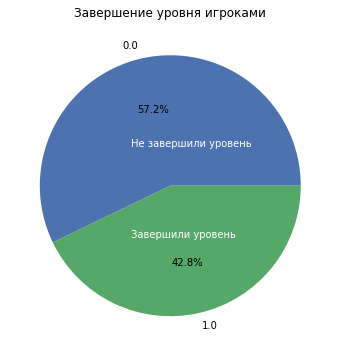

In [33]:
f, ax = plt.subplots(figsize=(15,6))
with plt.style.context('seaborn-deep'):
    pivot_data.groupby('finished_stage_1')['user_id'].count().plot(
        kind='pie', autopct='%1.1f%%', title='Завершение уровня игроками'
    )
ax.set_ylabel('')
ax.text(-0.3, -0.4,'Завершили уровень', color = 'white', fontsize = 10)
ax.text(-0.3, 0.3,'Не завершили уровень', color = 'white', fontsize = 10)

plt.show()

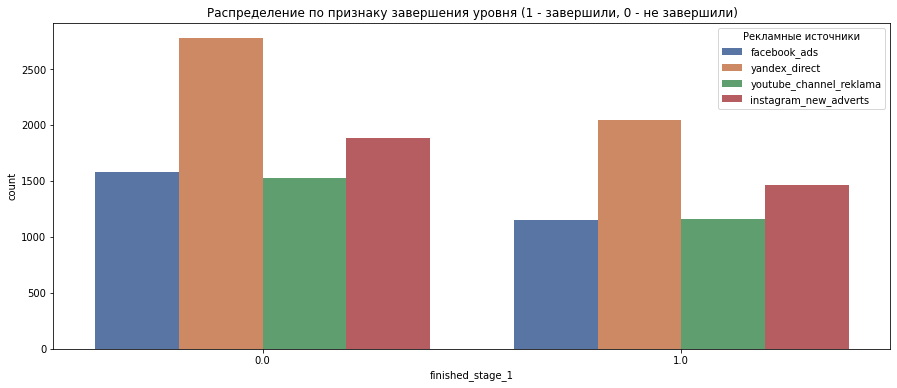

In [34]:
f, ax = plt.subplots(figsize=(15,6 ))
sns.countplot(data = pivot_data, x = 'finished_stage_1', hue = 'source')
plt.legend(title = 'Рекламные источники')
plt.title(f'Распределение по признаку завершения уровня (1 - завершили, 0 - не завершили)')
plt.show()

In [35]:
# доля пользователей, прошедших уровень по каналам
round(
    (
        pivot_data.groupby('source')['finished_stage_1'].sum() / pivot_data.groupby('source')['finished_stage_1'].count()
    ),2
)

source
facebook_ads               0.42
instagram_new_adverts      0.44
yandex_direct              0.42
youtube_channel_reklama    0.43
Name: finished_stage_1, dtype: float64

**Количество не завершивших уровень игроков на 14% больше, чем завершивших. По рекламным источникам каналы привлечения также практически не отличаются, показатели прохождения 42-44%. Чуть больше пользователей, прошедших первый уровень, у Инстаграм - 44%, чуть меньше у Фэйсбук и Яндекс - по 42%** 

**Оценим игроков, построивших 1 и более 1 здания**

In [36]:
# количество игроков, построивших больше 1 дома делим на общее число пользователей по источникам
pivot_data[pivot_data['cnt_build'] > 1].groupby('source')['user_id'].count() / pivot_data.groupby(
    'source'
)['user_id'].count()

source
facebook_ads               0.994864
instagram_new_adverts      0.996713
yandex_direct              0.996056
youtube_channel_reklama    0.995160
Name: user_id, dtype: float64

**Почти все пользователи из рекламных источников, играющие первый уровень, входят в игру, не бросают ее и строят более одного здания.**

### Стратегии
- Определим какими стратегиями пользуются игроки (доли по каналам привлечения)

In [37]:
#считаем доли: исключаем из вычислений категорию незавершивших, количество игроко в каждой из стратегий
# с разбивкой по источникам делим на количество игроков по источникам привлечения
pivot_data[pivot_data['category_user'] != 'other'].groupby('source')['category_user'].value_counts() / pivot_data[pivot_data['category_user'] != 'other'].groupby('source')['category_user'].count()


source                   category_user   
facebook_ads             war_strategy        0.660000
                         project_strategy    0.340000
instagram_new_adverts    war_strategy        0.675307
                         project_strategy    0.324693
yandex_direct            war_strategy        0.696376
                         project_strategy    0.303624
youtube_channel_reklama  war_strategy        0.672994
                         project_strategy    0.327006
Name: category_user, dtype: float64

**Вновь ситуация по рекламным каналам очень похожая - стратегию победы над противником, в зависимости от канала привлечения, выбирают 66-70% пользователей, соответственно через реализацию проекта на следующий уровень проходят - 30-34% пользователей. Чуть больше "воителей" пришли из Яндекса, чуть больше "исследователей" пришли из Фэйсбука.**

### Время прохождения
- Проанализируем время прохождения уровня: 1.Общее время всех игроков с начала до finished_stage_1. 2.С разбивкой по стратегиям: а)Время c начала до Project, от Project до finished_stage_1, б)с начала до finished_stage_1

**Общее время прохождения уровня для всех игроков**

In [38]:
# считаем время прохождения уровня и записываем в столбец сводной таблицы
pivot_data['timing'] = pivot_data['finish_flag'] - pivot_data['start_flag']

#смотрим описание данных
pivot_data['timing'].describe()

count                          5817
mean     11 days 20:37:59.561801616
std       4 days 01:37:33.183162346
min                 0 days 09:39:01
25%                 9 days 05:13:21
50%                11 days 13:28:44
75%                14 days 05:15:16
max                30 days 21:58:53
Name: timing, dtype: object

**Общее время прохождения по каналам привлечения**

In [39]:
def desc_timing (pivot_data, net):
    '''
    Функция для описания среднего, минимального и максимального времени прохождения уровня по источникам
    
    '''
    mean = pivot_data[pivot_data['source']== net]['timing'].mean()
    min_max = pivot_data[pivot_data['source']== net]['timing'].max() - pivot_data[pivot_data['source']== net]['timing'].min()
       
   
    return print(f'Для источника {net} среднее - {mean}, размах значений {min_max}.')

In [40]:
# создаем список источников рекламы
net = list(pivot_data['source'].unique())

# вызываем функцию
for i in net:
    desc_timing(pivot_data, i)

Для источника facebook_ads среднее - 11 days 20:35:33.946086956, размах значений 28 days 21:07:39.
Для источника yandex_direct среднее - 11 days 19:24:02.402546523, размах значений 29 days 23:21:29.
Для источника youtube_channel_reklama среднее - 11 days 21:46:25.266609145, размах значений 26 days 05:43:20.
Для источника instagram_new_adverts среднее - 11 days 21:28:48.419508867, размах значений 29 days 23:57:23.


**И вновь ситуация достаточно похожая: как в целом для всех игроков, так и игроков по рекламным источникам среднее время прохождения уровня - 11 дней, но при этом для Ютуб все значения укладываются в пределах 26 дней, а для других источников 28-29 дней.**

**Время прохождения уровня с разбивкой по стратегиям**

In [41]:
# посмотрим описание данных о времени прохождения уровня для всех игроков стратегии war_strategy
pivot_data.query('category_user =="war_strategy"')['timing'].describe()

count                          3951
mean     11 days 02:30:24.076183244
std       4 days 02:17:54.287406787
min                 0 days 09:39:01
25%          8 days 07:01:19.500000
50%                10 days 19:01:37
75%         13 days 10:33:17.500000
max                30 days 21:58:53
Name: timing, dtype: object

In [42]:
# посмотрим описание данных о времени прохождения уровня для всех игроков стратегии project_strategy
pivot_data.query('category_user =="project_strategy"')['timing'].describe()

count                          1866
mean     13 days 11:00:49.135048231
std       3 days 12:11:01.977069676
min                 5 days 03:22:27
25%         10 days 22:49:58.750000
50%                13 days 00:45:41
75%         15 days 13:47:23.750000
max                29 days 03:13:43
Name: timing, dtype: object

**Видим первые значимые отличия: игроки, выбирающие стратегию исследователя (project) тратят на прохождение игры в среднем 13 дней, игроки-"воители" - 11 дней. Кроме того размах значений у игроков project меньше.**

Посмотрим данные в разрезе рекламных источников.

In [43]:
# узнаем среднее время прохождения уровня по рекламным источникам игроками war_strategy
for i in net:
    print(pivot_data.loc[
        (
        pivot_data['category_user'] =='war_strategy'
    ) & (
        pivot_data['source'] == i
    )
    ]['timing'].mean())   

11 days 01:15:10.897233201
11 days 03:06:11.998593530
11 days 02:32:47.853846153
11 days 02:34:45.703030303


In [44]:
# узнаем среднее время прохождения уровня по рекламным источникам игроками project_strategy
for i in net:
    print(pivot_data.loc[
        (
        pivot_data['category_user'] =='project_strategy'
    ) & (
        pivot_data['source'] == i
    )
    ]['timing'].mean())

13 days 10:08:04.570332480
13 days 08:46:45.812903225
13 days 13:20:37.989445910
13 days 12:47:25.834033613


**Вновь ситуация повторяет общий тренд - рекламные источники внутри стратегий не показывают видимой разницы во времени прохождения уровня.**

Механика игры для игрока-исследователя(project_strategy), прошедшего уровень, такая:

строим → 🚩project → (можем продолжить строить, или вступить в бой) → 🚩finished_stage_1

**Мы узнали, что до флажка finished_stage_1 пользователи стратегии project_strategy тратят в среднем 13 дней, посмотрим сколько времени уходит до флажка project (реализации проекта постройки орбитальной станции).**

In [45]:
# у игроков стратегии project считаем время до флажка - project
pivot_data['project_timing'] = pivot_data['project_flag'] - pivot_data['start_flag']
# смотрим описание данных
pivot_data['project_timing'].describe()

count                          1866
mean     11 days 21:16:06.260986066
std       3 days 15:11:43.443256769
min                 3 days 13:28:25
25%          9 days 07:51:47.250000
50%                11 days 07:12:24
75%         13 days 21:14:20.500000
max                28 days 19:53:40
Name: project_timing, dtype: object

**Данные показали, что в целом игроки project-стратегии доходят до реализации проекта за те же 11 дней, что и игроки стратегии war до окончания уровня, но так как переход на следующий уровень после флажка project не автоматический, игроки остаются играть уровень в среднем еще на 2 дня.**

Посмотрим эти данные с разбивкой по рекламным каналам

In [46]:
for i in net:
    print(pivot_data.loc[pivot_data['source'] == i]['project_timing'].mean())

11 days 21:30:41.567774936
11 days 17:00:40.208064516
12 days 02:02:48.686015831
11 days 22:48:32.876050420


In [47]:
# посмотрим какой рекламный канал немного отличается от других
net[2]

'youtube_channel_reklama'

**До флажка реализации проекта в среднем дольше на 1 день играют пользователи, пришедшие из ютуб, остальным нужны в среднем 11 дней.**

### Целевое действие - building
- Посчитаем: как часто совершается "целевое" действие (постройка объекта): назовем максимум, минимум и среднее количество построенных зданий на пользователя по каналам.
- Выясним наиболее предпочтительный тип здания по каналам.
- Посмотрим сколько зданий строят в разбиении по стратегии прохождения игры.

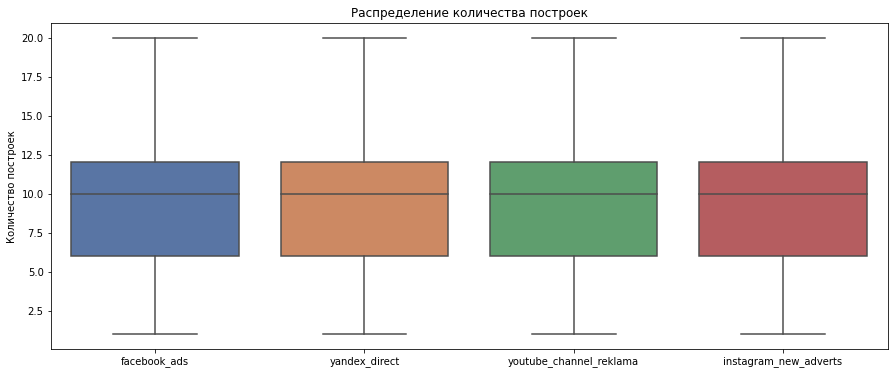

In [48]:
# посмотрим на распределение количества построек для всех игроков по каналам привлечения
f, ax = plt.subplots(figsize=(15,6 ))
sns.boxplot(data = pivot_data, x = 'source', y = 'cnt_build')
ax.set_title('Распределение количества построек')
ax.set_xlabel('')
ax.set_ylabel('Количество построек')
plt.show()

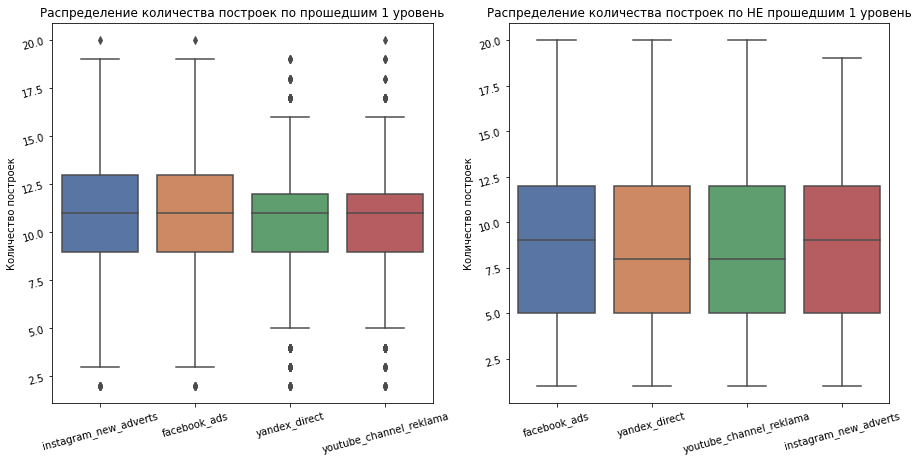

In [49]:
# строим боксплоты для распределения количества построек по признаку прохождения уровня

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
ax = ax.flatten()

sns.boxplot(data = pivot_data.loc[pivot_data ['finished_stage_1'] == 1], x = 'source', y = 'cnt_build', ax=ax[0]) 
sns.boxplot(data = pivot_data.loc[pivot_data ['finished_stage_1'] == 0], x = 'source', y = 'cnt_build', ax=ax[1]) 

ax[0].set_title('Распределение количества построек по прошедшим 1 уровень')
ax[1].set_title('Распределение количества построек по НЕ прошедшим 1 уровень')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_ylabel('Количество построек')
ax[1].set_ylabel('Количество построек')
ax[0].tick_params(labelrotation = 15)
ax[1].tick_params(labelrotation = 15)
fig.show()

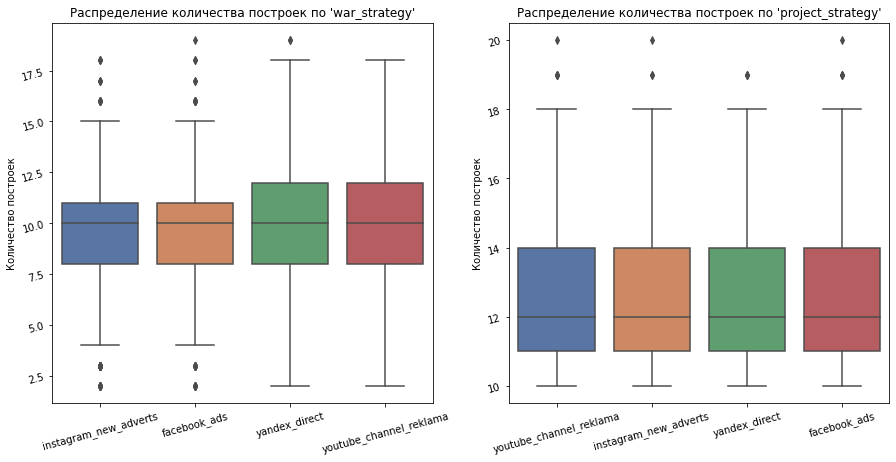

In [50]:
# строим боксплоты для распределения количества построек по стратегии прохождения игры

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
ax = ax.flatten()

sns.boxplot(data = pivot_data.loc[pivot_data ['category_user'] == 'war_strategy'], x = 'source', y = 'cnt_build', ax=ax[0]) 
sns.boxplot(data = pivot_data.loc[pivot_data ['category_user'] == 'project_strategy'], x = 'source', y = 'cnt_build', ax=ax[1]) 

ax[0].set_title('Распределение количества построек по \'war_strategy\'')
ax[1].set_title('Распределение количества построек по \'project_strategy\'')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_ylabel('Количество построек')
ax[1].set_ylabel('Количество построек')
ax[0].tick_params(labelrotation = 15)
ax[1].tick_params(labelrotation = 15)
fig.show()

**Среднее количество построек на всех игроков - 9**

**Общие итоги о постройках по каналам привлечения:**
- для завершивших уровень - среднее количество построек - 10, для не завершивших, ожидаемо меньше - 8
- игроки, выбирающие стратегию project, строят в среднем больше зданий - их показатель 12 зданий (для war-strategy - среднее количество построек на игрока - 9)
- для завершения игры в стратегии war некоторым игрокам хватает и 2 построек, тем кто реализуеи проект -  минимально понадобилось 10 зданий. Максимум по стратегиям так сильно не отличается: project_strategy - 19-20 построек, war_strategy - 18-19 построек.

Далее проанализируем наиболее популярные типы построек:

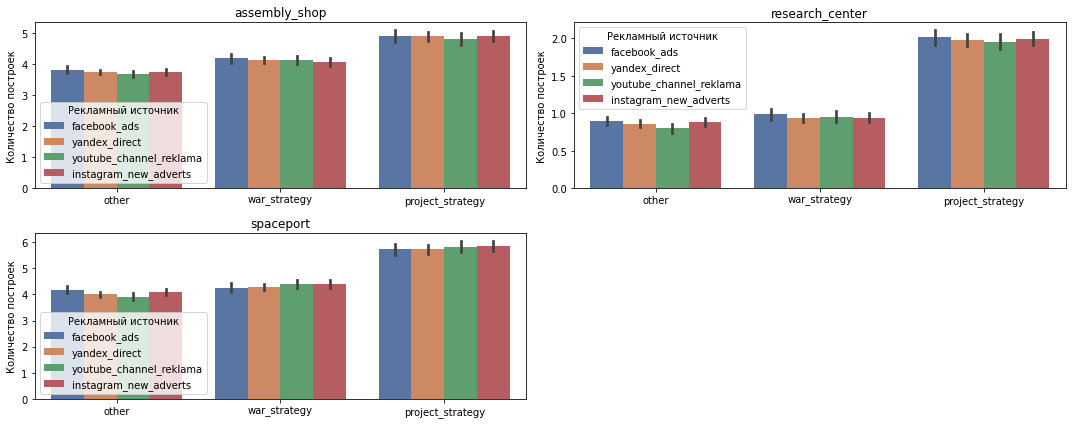

In [51]:
# среднее количество типов зданий  в разрезе рекламных каналов и категорийй игроков
list_type =['assembly_shop', 'research_center', 'spaceport']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,6))
ax=ax.flatten()

for i in range(len(list_type)):
    sns.barplot(data = pivot_data, x = 'category_user', y = list_type[i], hue='source', ax=ax[i])
    ax[i].set_title(f'{list_type[i]}')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Количество построек')
    ax[i].legend(title = 'Рекламный источник')
    
fig.delaxes(ax[-1])
fig.tight_layout()
fig.show()


**Общие итоги о типах построек по каналам привлечения:**
- для всех игроков - среднее количество зданий на уникального пользователя: assembly_shop - 4 здания, spaceport - 4 здания, research_center - 1 здание
- для игроков, прошедших на следующий уровень, среднее количество домов повторяет общие данные. Для игроков еще не прошедших уровень, показатели уже очень близки к показателям игроков, перешедших на 2 уровень, что дает надежду на бОльшую конверсию в переход на следующий уровень.
- по стратегиям, ожидаемо чуть меньше построек каждого типа у воителей (war_strategy), чуть больше - у исследователей (project_strategy), аномального преимущества какого-то типа зданий в разрезе стратегий и каналов привлечения также нет.

### Стоимость привлечения
- Проанализируем стоимость привлечения пользователя, посчитаем окупаемость, а именно сопоставим количество построенных объектов (возможные заработанные деньги) с расходами на рекламу

In [52]:
# группируем для анализа по дням привлечения и источникам
money = pivot_data.groupby(['first_day','source']).agg(
    {'user_id':'nunique', 'revenue':'sum', 'cnt_build':'mean'}
).rename(columns={'user_id':'cohort_size', 'revenue':'cohort_revenue'}).sort_values(
    by=['source','first_day']
).reset_index()

# включаем в получившуюся таблицу с данными информацию о расходах на рекламу из таблицы cost
money['cost'] = cost['cost']

# предполагаемая прибыль от рекламных показов в игре
money['profit'] = money['cohort_revenue'] - money['cost']


# отобразим цветом максимумы и минимумы значений по столбцам
numeric_columns = money.drop(columns=['first_day', 'source']).columns
money.style.format({i: '{:.2f}' for i in numeric_columns}) \
     .highlight_max(color='yellowgreen', subset=numeric_columns) \
     .highlight_min(color='coral', subset=numeric_columns)

,first_day,source,cohort_size,cohort_revenue,cnt_build,cost,profit
0,2020-05-04,facebook_ads,1184.00,874.58,10.55,935.88,-61.30
1,2020-05-05,facebook_ads,694.00,482.65,9.94,548.35,-65.70
2,2020-05-06,facebook_ads,345.00,216.09,8.95,260.19,-44.10
3,2020-05-07,facebook_ads,224.00,125.23,7.99,177.98,-52.75
4,2020-05-08,facebook_ads,139.00,66.43,6.83,111.77,-45.34
5,2020-05-09,facebook_ads,84.00,41.93,7.13,68.01,-26.08
6,2020-05-10,facebook_ads,56.00,22.26,5.68,38.72,-16.46
7,2020-05-04,instagram_new_adverts,1452.00,1059.45,10.42,943.20,116.25
8,2020-05-05,instagram_new_adverts,796.00,545.02,9.78,502.93,42.09
9,2020-05-06,instagram_new_adverts,472.00,295.47,8.94,313.97,-18.50


**Вместе с количеством привлеченных игроков день ото дня снижалось и среднее количество построенных домов (обратим внимание, что среднее время прохождения уровня 11-13 дней, а это значит, что у игроков, привлеченных 10 мая было время выйти на средние показатели постройки зданий первых 3-4 когорт. Предположу возможные причины: игрок уже знал как пройти уровень, наименьшими усилиями, - прохождение уровня было облегчено разработчиками, - технические неполадки???** 

Сформируем сводную таблицу с группировкой по источнику привлечения и посчитаем метрики: cac(стоимость привлечения 1 пользователя), прибыль и окупаемость рекламных вложений(romi).

In [53]:
source_money = money[['source','cohort_size', 'cohort_revenue', 'cost']].groupby('source').sum()
source_money['cac'] = source_money['cost'] / source_money['cohort_size']
source_money['profit'] = source_money['cohort_revenue'] - source_money['cost']
source_money['romi'] = source_money['profit'] / source_money['cost']*100
source_money = source_money.rename(columns={ 'cohort_size':'cnt_user', 'cohort_revenue':'revenue'})
source_money.reset_index()

,source,cnt_user,revenue,cost,cac,profit,romi
0,facebook_ads,2726,1829.17,2140.904643,0.785365,-311.734643,-14.560884
1,instagram_new_adverts,3347,2227.05,2161.441691,0.645785,65.608309,3.035396
2,yandex_direct,4817,3152.24,2233.111449,0.463590,919.128551,41.159099
3,youtube_channel_reklama,2686,1748.46,1068.119204,0.397662,680.340796,63.695212


**Фэйсбук не окупил рекламные расходы на 14%, совсем незначительную окупаемость показал Инстаграм, результат в 41% окупаемость показал Яндекс, самая высокая окупаемость у Ютуба, но этот канал привлек меньше всего пользователей**

### Итоги

In [54]:
# сформируем данные по основным критериям проверки поведения пользователя
all_result = pivot_data.groupby('source').agg(
    {
        'user_id':'count',
        'cnt_session':'mean',
        'finished_stage_1':'sum',
        'strategy_project':'sum',
        'cnt_build':'mean',
        'revenue':'mean'
    }
).reset_index()

all_result['share_finished'] = round((all_result['finished_stage_1']/all_result['user_id']),2)
all_result['share_project'] = round((all_result['strategy_project']/all_result['finished_stage_1']),2)
all_result = all_result.rename(
    columns = {
        'cnt_session':'session_mean',
        'finished_stage_1':'finished_cnt',
        'strategy_project': 'project_cnt',
        'revenue':'revenue_mean',
        'cnt_build':'build_mean'
    }
)
all_result

,source,user_id,session_mean,finished_cnt,project_cnt,build_mean,revenue_mean,share_finished,share_project
0,facebook_ads,2726,9.585840,1150.0,391.0,9.585840,0.671009,0.42,0.34
1,instagram_new_adverts,3347,9.505527,1466.0,476.0,9.505527,0.665387,0.44,0.32
2,yandex_direct,4817,9.348557,2042.0,620.0,9.348557,0.654399,0.42,0.30
3,youtube_channel_reklama,2686,9.299330,1159.0,379.0,9.299330,0.650953,0.43,0.33


In [55]:
# данные по ожидаемой монетизации
source_money

,cnt_user,revenue,cost,cac,profit,romi
source,,,,,,
facebook_ads,2726,1829.17,2140.904643,0.785365,-311.734643,-14.560884
instagram_new_adverts,3347,2227.05,2161.441691,0.645785,65.608309,3.035396
yandex_direct,4817,3152.24,2233.111449,0.463590,919.128551,41.159099
youtube_channel_reklama,2686,1748.46,1068.119204,0.397662,680.340796,63.695212


Судя по двум сводным таблицам выше, данные по рекламным каналам очень похожи, еще раз укажем на те отличия, что были обнаружены и значимы для исследования:

- По рекламным источникам каналы привлечения практически не отличаются, показатели прохождения уровня - 42-44%. Чуть больше пользователей, прошедших первый уровень, у Инстаграм - 44%, чуть меньше у Фэйсбук и Яндекс - по 42%** 
- Стратегию победы над противником, в зависимости от канала привлечения, выбирают 66-70% пользователей, соответственно через реализацию проекта на следующий уровень проходят - 30-34% пользователей. Чуть больше "воителей" пришли из Яндекса, чуть больше "исследователей" пришли из Фэйсбука.
- среднее время прохождения уровня для всех игроков - 11 дней, пользователи, выбирающие стратегию исследователя (project) тратят на прохождение игры в среднем 13 дней, игроки-"воители" - 11 дней. При этом исследователи реализуют проект так же в среднем за 11 дней и могут перейти на следующий уровень сразу, но все же остаются в игре еще в среднем на 2 дня.
- Среднее количество построек на всех игроков - 9. Для завершивших уровень - среднее количество построек - 10, для не завершивших, ожидаемо меньше - 8. Игроки, выбирающие стратегию project, строят в среднем больше зданий - их показатель 12 зданий (для war-strategy - среднее количество построек на игрока - 9). Для завершения игры в стратегии war некоторым игрокам хватает и 2 построек, тем, кто реализует проект - минимально понадобилось 10 зданий.
- Для всех игроков - среднее количество типов зданий на уникального пользователя: assembly_shop - 4 здания, spaceport - 4 здания, research_center - 1 здание. По стратегиям, ожидаемо чуть меньше построек каждого типа у воителей (war_strategy), чуть больше - у исследователей (project_strategy), аномального преимущества какого-то типа зданий в разрезе стратегий также нет.

Разница между каналами привлечения ярко обозначилась при анализе модели монетизации и разница эта формируется в целом из различной стоимости рекламы.
- Фэйсбук не окупил рекламные расходы на 14%, хотя доля исследователей (project_strategy) в нем больше, чем в остальных каналах.
- Cовсем незначительную окупаемость показал Инстаграм - 3%
- Хороший сводный результат у Яндекса -  41% окупаемости, сформировавшийся в том числе и за счет бОльшего числа привлеченных игроков
- Самая высокая окупаемость у Ютуба - 63%, но из него в игру привлечены меньше всего пользователей. 



## Проверка гипотез

### Гипотеза о времени и стратегиях

Мы выяснили, что пользователи, выбирающие стратегию исследователя (project) тратят на прохождение игры в среднем 13 дней, игроки-"воители" - 11 дней. Далее проверим не является ли такая разница случайной. Для проверки будем использовать t-test

**Гипотеза о равенстве двух средних:**
- H0 - среднее время прохождения уровня через реализацию проекта (project_strategy) и через победу над первым игроком ('war_strategy') равны
- Н1 - среднее время прохождения уровня через реализацию проекта (project_strategy) и через победу над первым игроком ('war_strategy') не равны

Уровень значимости alpha примем за 0.05, общепринятое значение, которое позволит уменьшить риск (в отличие от 0,01) ошибки (например, риск не отвергнуть ложную нулевую гипотезу).

In [56]:
# формируем выборки
sample_project = pivot_data.loc[pivot_data['category_user'] == 'project_strategy']['timing'].astype('int')

sample_war = pivot_data.loc[pivot_data['category_user'] == 'war_strategy']['timing'].astype('int')


In [57]:
# задаем уровень значимости
alpha = .05

# проводим тест
result = st.ttest_ind(sample_project, sample_war, equal_var=False)

# формируем результат
print('р-значение', result.pvalue)
if result.pvalue < alpha:
   print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя')

р-значение 5.708058235070199e-107
Отвергаем нулевую гипотезу: разница статистически значима


#### Результат
По результатам т-теста нулевая гипотеза о равенстве средних не подтвердилась, была принята альтернативная гипотеза, о том что среднее время прохождения уровня для стратегий не равны. Разница неслучайна, есть значимые отличия между двумя выборками.

### Гипотеза о прохождении уровня и рекламных каналах

Проверим вовлеченность пользователя в игру, по каналам привлечения выясним равны ли доли пользователей, прошедших уровень. 

Сформулируем гипотезу о равенстве долей:
- Н0 - доли пользователей, завершивших уровень равны
- Н1 - доли пользователей, завершивших уровень не равны

Так как на одних и тех же данных будет проводиться множественный тест, применим поправку Бонферрони к уровню значимости.

In [58]:
# подготовим функцию для эксперимента
def z_test(data1, data2):
   
    alpha=0.05/6 # поправка Бонферрони для множественного теста
    finished = []
    users = []
    
    
# заполняем список finished - количество пользователей, прошедших уровень  
    x = data1.loc[data1['finished_stage_1'] == 1]['user_id'].count()
    y = data2.loc[data2['finished_stage_1'] == 1]['user_id'].count()
    finished.append(x)
    finished.append(y)
# заполняем список users - количество пользователей  
    x_s = len(data1)
    y_s = len(data2)
    users.append(x_s)
    users.append(y_s)    
    
# пропорция прошедших уровень по группам
    p1 = finished[0]/users[0]
    p2 = finished[1]/users[1]
    
# пропорция прошедших уровень в комбинированном датасете
    p_combined = (finished[0] + finished[1]) / (users[0] + users[1])
    
# разница пропорций в датасетах
    difference = p1-p2
    
# считаем статистику в std нормального распределения
    z_value = difference/mth.sqrt(
    p_combined * (1 - p_combined)
    * (1 / users[0] + 1 / users[1]))
    
# задаем стандартное нормальное распределение
    distr = st.norm(0,1)
    
# считаем p_value
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print ('p-значение:', p_value)
    
# интерпретация результата
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу:нет оснований считать доли разными')

In [59]:
# подготовим выборки
fb = pivot_data.loc[pivot_data['source'] == 'facebook_ads']
yandex = pivot_data.loc[pivot_data['source'] == 'yandex_direct']
youtube = pivot_data.loc[pivot_data['source'] == 'youtube_channel_reklama']
insta = pivot_data.loc[pivot_data['source'] == 'instagram_new_adverts']

Далее проведем попарную проверку:

In [60]:
z_test(fb, yandex)

p-значение: 0.8624388026512437
Не получилось отвергнуть нулевую гипотезу:нет оснований считать доли разными


In [61]:
z_test(fb, youtube)

p-значение: 0.4737412931629539
Не получилось отвергнуть нулевую гипотезу:нет оснований считать доли разными


In [62]:
z_test(fb, insta)

p-значение: 0.20644137086490777
Не получилось отвергнуть нулевую гипотезу:нет оснований считать доли разными


In [63]:
z_test(yandex, youtube)

p-значение: 0.5244230207169549
Не получилось отвергнуть нулевую гипотезу:нет оснований считать доли разными


In [64]:
z_test(yandex, insta)

p-значение: 0.20595754565724533
Не получилось отвергнуть нулевую гипотезу:нет оснований считать доли разными


In [65]:
z_test(youtube, insta)

p-значение: 0.6123664865502236
Не получилось отвергнуть нулевую гипотезу:нет оснований считать доли разными


#### Результаты
Значения p_value значительно превосходят уровень значимости. Различия по группам не имеют статистической значимости, ни в одном из тестов не получилось отвергнуть нулевую гипотезу.

## Результат исследования

На этапе предобработки только в одной таблице (из 3 поступивших для анализа) была удалена 1 строка (дубликат), остальные данные сохранены. Все пропуски в таблицах связаны с механикой прохождения игры, были оставлены.

Из исследовательского анализа мы выяснили:
- Данные представлены с 4 мая по 5 июня
- Закончили уровень и перешли на следующий 42.85% игроков, из них 68% игроков закончили уровень, одержав победу в сражении, 32% пользователей использовали стратегию выполнения проекта.
- Всего игроков - 13576, из них - 35% пришли из яндекс-директ, 25% - из инстаграмм, по 20% из фэйсбука и ютуба.
- Пользователи построили - 127956 зданий, самые популярные типы зданий космопорты и сборочные цеха.
- Расходы на рекламу - 7603 у.е. Примерно поровну был распределен бюджет между Яндекс-директ(2233 у.е.), инстаграм(2161 у.е.) и фэйсбук (2140у.е.). В два раза меньше денег получил ютуб.

Анализ поведения игроков показал, что пользователи пришедшие из разных источников очень похожи.

Значимыми различиями стало лишь время завершения уровня:
- среднее время прохождения уровня для всех игроков - 11 дней, пользователи, выбирающие стратегию исследователя (project) тратят на прохождение игры в среднем 13 дней, игроки-"воители" - 11 дней. При этом исследователи реализуют проект так же в среднем за 11 дней и могут перейти на следующий уровень сразу, но все же остаются в игре еще в среднем на 2 дня. Проверка гипотезы о равенстве времени прохождения уровня через разные  стратегии показала, что разница во времени прохождения уровня действительно есть и она не случайна.

и количество построек с разбивкой по стратегиям:
- Игроки, выбирающие стратегию project, строят в среднем больше зданий - их показатель 12 зданий (для war-strategy - среднее количество построек на игрока - 9). Для завершения игры в стратегии war некоторым игрокам хватает и 2 построек, тем кто реализует проект - минимально понадобилось 10 зданий.

Разница между каналами привлечения ярко обозначилась при анализе модели монетизации и разница эта сформировалаль в целом из-за различной стоимости рекламы:
- Фэйсбук не окупил рекламные расходы на 14%, хотя доля исследователей (project_strategy) в нем больше, чем в остальных каналах.
- Cовсем незначительную окупаемость показал Инстаграм - 3%
- Хороший сводный результат у Яндекса - 41% окупаемости, сформировавшийся в том числе и за счет бОльшего числа привлеченных игроков
- Самая высокая окупаемость у Ютуба - 63%, но из него в игру привлечены меньше всего пользователей.

**Наиболее выгодными каналами привлечения пользователей, при предлагаемой модели монетизации, можно считать Яндекс и Ютуб. Project_strategy - наиболее выгодная стратегия для модели монетизации. War_strategy - наиболее выгодна для конверсии в переход на следующий уровень.**